## Setup Mario

What to install:
make a conda environment python-3.8
install gymnasium, gym, gym_super_mario_bros, nes_py, pyglet, matplotlib, pyvirtualdisplay, stable_baselines3, python-opencv, and Xquartz as a tool for mac

In [1]:
# !pip install gym_super_mario_bros --upgrade
# !pip install --upgrade nes-py
# !pip install pyglet --upgrade

!pip list


Package                   Version
------------------------- --------------
absl-py                   2.1.0
anyio                     4.3.0
appnope                   0.1.4
argon2-cffi               23.1.0
argon2-cffi-bindings      21.2.0
arrow                     1.3.0
asttokens                 2.4.1
async-lru                 2.0.4
attrs                     23.2.0
Babel                     2.14.0
backcall                  0.2.0
beautifulsoup4            4.12.3
bleach                    6.1.0
Brotli                    1.0.9
cached-property           1.5.2
certifi                   2024.2.2
cffi                      1.14.6
charset-normalizer        3.3.2
cloudpickle               3.0.0
comm                      0.2.2
contourpy                 1.1.1
cycler                    0.12.1
debugpy                   1.6.7
decorator                 5.1.1
defusedxml                0.7.1
entrypoints               0.4
exceptiongroup            1.2.0
executing                 2.0.1
Farama-Notifications 

In [2]:
import gymnasium as gym
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
import os
from gymnasium.wrappers import TimeLimit, StepAPICompatibility
from gymnasium.utils.step_api_compatibility import step_api_compatibility
from gymnasium.wrappers.compatibility import EnvCompatibility
from gymnasium.wrappers.vector_list_info import VectorListInfo
from gymnasium.spaces import Box

In [3]:
SIMPLE_MOVEMENT #only 7 actions simplified so the AI can do it, NOOP is no operation, 

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [4]:
os.environ['DISPLAY'] = ':0'

In [5]:
# import pyglet

# window = pyglet.window.Window()


In [6]:
# Custom JoypadSpace to handle rendering and step method compatibility
class CustomJoypadSpace(gym.Wrapper):
    """An environment wrapper to convert binary to discrete action space."""

    _button_map = {
        'right':  0b10000000,
        'left':   0b01000000,
        'down':   0b00100000,
        'up':     0b00010000,
        'start':  0b00001000,
        'select': 0b00000100,
        'B':      0b00000010,
        'A':      0b00000001,
        'NOOP':   0b00000000,
    }

    @classmethod
    def buttons(cls) -> list:
        """Return the buttons that can be used as actions."""
        return list(cls._button_map.keys())

    def __init__(self, env: gym.Env, actions: list):
        super().__init__(env)
        self.action_space = gym.spaces.Discrete(len(actions))
        self._action_map = {}
        self._action_meanings = {}
        for action, button_list in enumerate(actions):
            byte_action = 0
            for button in button_list:
                byte_action |= self._button_map[button]
            self._action_map[action] = byte_action
            self._action_meanings[action] = ' '.join(button_list)

    def step(self, action):
        result = self.env.step(self._action_map[action])
        if len(result) == 4:
            observation, reward, done, info = result
            terminated = done
            truncated = False
        elif len(result) == 5:
            observation, reward, terminated, truncated, info = result
        else:
            raise ValueError(f"Unexpected number of values returned from step: {len(result)}")
        return observation, reward, terminated, truncated, info

    def reset(self, **kwargs):
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple) and len(result) == 2:
            observation, info = result
            return observation, info
        elif isinstance(result, (list, np.ndarray)):
            observation = result
            info = {}
            return observation, info
        else:
            raise ValueError(f"Unexpected number of values returned from reset: {len(result)}")

    def get_keys_to_action(self):
        old_keys_to_action = self.env.unwrapped.get_keys_to_action()
        action_to_keys = {v: k for k, v in old_keys_to_action.items()}
        keys_to_action = {}
        for action, byte in self._action_map.items():
            keys = action_to_keys[byte]
            keys_to_action[keys] = action
        return keys_to_action

    def get_action_meanings(self):
        actions = sorted(self._action_meanings.keys())
        return [self._action_meanings[action] for action in actions]


In [7]:
# Function to display frames
def display_frame(frame):
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [8]:
def unwrap_env(env):
    while hasattr(env, "env"):
        env = env.env
    return env

In [9]:
# Create the Super Mario Bros environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
print(f"Initial environment created: {env}")

# Unwrap the initial environment to remove the gym TimeLimit wrapper
env = unwrap_env(env)
print(f"Environment after unwrapping: {env}")

# Apply EnvCompatibility wrapper to ensure the environment uses the new API
env = EnvCompatibility(env, render_mode='human')
print(f"After applying EnvCompatibility wrapper: {env}")

# Apply StepAPICompatibility wrapper to ensure the step method returns five values
env = StepAPICompatibility(env, output_truncation_bool=True)
print(f"After applying StepAPICompatibility wrapper: {env}")

# Apply CustomJoypadSpace wrapper
env = CustomJoypadSpace(env, SIMPLE_MOVEMENT)
print(f"After applying CustomJoypadSpace wrapper: {env}")

# Apply TimeLimit wrapper from gymnasium to set a maximum number of steps
env = TimeLimit(env, max_episode_steps=10000)
print(f"After applying TimeLimit wrapper: {env}")

# Function to display frames
def display_frame(frame):
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

# Example usage
obs, info = env.reset()  # Adjusted to handle the new API
#print(f"Type of obs: {type(obs)}, Info: {info}")

done = False
# ==========================================uncomment below to see simple running
# for step in range(100000):
#     if done:
#        obs, info =  env.reset()
#     action = env.action_space.sample()  # Take a random action
#     result = env.step(action)
    
#     obs, reward, terminated, truncated, info = result
#     done = terminated  # Use 'terminated' to control the loop
#     env.render()
# while not done:
#     action = env.action_space.sample()  # Take a random action
#     result = env.step(action)
    
#     obs, reward, terminated, truncated, info = result
#     done = terminated  # Use 'terminated' to control the loop
#     env.render()


/Users/juliansinger/miniforge3/envs/mario_env2/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/juliansinger/miniforge3/envs/mario_env2/lib/python3.8/site-packages/gymnasium/wrappers/compatibility.py:60: DeprecationWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v1.0. Instead use `gymnasium.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`
  logger.deprecation(


Initial environment created: <TimeLimit<OrderEnforcing<PassiveEnvChecker<SuperMarioBrosEnv<SuperMarioBros-v0>>>>>
Environment after unwrapping: <SuperMarioBrosEnv<SuperMarioBros-v0>>
After applying EnvCompatibility wrapper: <EnvCompatibility<SuperMarioBrosEnv<SuperMarioBros-v0>>>
After applying StepAPICompatibility wrapper: <StepAPICompatibility<EnvCompatibility<SuperMarioBrosEnv<SuperMarioBros-v0>>>>
After applying CustomJoypadSpace wrapper: <CustomJoypadSpace<StepAPICompatibility<EnvCompatibility<SuperMarioBrosEnv<SuperMarioBros-v0>>>>>
After applying TimeLimit wrapper: <TimeLimit<CustomJoypadSpace<StepAPICompatibility<EnvCompatibility<SuperMarioBrosEnv<SuperMarioBros-v0>>>>>>


In [10]:
env.close()

In [11]:
env.observation_space.shape #shows we will hv e a 240 x 256 pixel space with rgb colors

(240, 256, 3)

## Preprocess Environment

In [12]:
#import frame stacking and gray scale
from gymnasium.wrappers import FrameStack, GrayScaleObservation
#import vectorization wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
from matplotlib import pyplot as plt

In [13]:
# Custom GrayScaleObservation for debugging

class DebugGrayScaleObservation(GrayScaleObservation):
    def __init__(self, env, keep_dim=False):
        print(f"Observation space before GrayScale: {env.observation_space}")
        print(f"Type of observation space before GrayScale: {type(env.observation_space)}")
        print(f"Initialization arguments - env: {env}, keep_dim: {keep_dim}")
        print(f"isinstance(env.observation_space, Box): {isinstance(env.observation_space, Box)}")
        print(f"len(env.observation_space.shape) == 3: {len(env.observation_space.shape) == 3}")
        print(f"env.observation_space.shape[-1] == 3: {env.observation_space.shape[-1] == 3}")
        assert (
            isinstance(env.observation_space, Box)
            and len(env.observation_space.shape) == 3
            and env.observation_space.shape[-1] == 3
        ), "Observation space is not compatible with GrayScaleObservation"
        super().__init__(env, keep_dim)
        print(f"Observation space after GrayScale: {self.observation_space}")

    def observation(self, observation):
        print(f"Observation before conversion: {observation.shape}")
        observation = super().observation(observation)
        print(f"Observation after conversion: {observation.shape}")
        return observation
    def step(self, action):
        print("GrayScaleObservation step")
        result = super().step(action)
        print(f"GrayScaleObservation step result: {result}")
        return result

In [14]:
from gymnasium.spaces import Box as GymnasiumBox
import gymnasium.spaces

def convert_observation_space(observation_space):
    #print(f"Converting observation space of type: {type(observation_space)}")
    if isinstance(observation_space, GymnasiumBox):
        return observation_space
    else:
        return GymnasiumBox(
            low=observation_space.low,
            high=observation_space.high,
            shape=observation_space.shape,
            dtype=observation_space.dtype
        )

In [15]:
# Custom wrapper to ensure reset returns a tuple
class CustomResetWrapper(gym.Wrapper):
    def reset(self, **kwargs):
        #print("CustomResetWrapper reset")
        #print("CustomResetWrapper reset with kwargs:", kwargs)
        result = self.env.reset(**kwargs)
        if isinstance(result, tuple):
            obs, info = result
        else:
            obs, info = result, {}
        return obs, info


In [16]:
# Custom wrapper to set num_envs attribute
class SetNumEnvsWrapper(gym.Wrapper):
    def __init__(self, env, num_envs):
        super().__init__(env)
        self.num_envs = num_envs

In [17]:
# #framestack allows us to capture frames while playing, lets the model see what happened in last few frames for Mario's moveement, enemy movement
# #graysclae will let us convert  the game into grayscale, reduce the info needed

# # Base environment
# env = gym_super_mario_bros.make('SuperMarioBros-v0')

# # Unwrap the initial environment to remove the gym TimeLimit wrapper
# env = unwrap_env(env)


# # Apply EnvCompatibility wrapper to ensure the environment uses the new API
# env = EnvCompatibility(env, render_mode='human')

# # Apply StepAPICompatibility wrapper to ensure the step method returns five values
# env = StepAPICompatibility(env, output_truncation_bool=True)


# # Apply CustomJoypadSpace wrapper to simplify controls
# env = CustomJoypadSpace(env, SIMPLE_MOVEMENT)


# # Convert observation space to gymnasium space
# env.observation_space = convert_observation_space(env.observation_space)

# # # Apply DebugGrayScaleObservation wrapper
# # env = DebugGrayScaleObservation(env)

# # Apply TimeLimit wrapper from gymnasium to set a maximum number of steps
# env = TimeLimit(env, max_episode_steps=10000)

# #grayscale
# env = GrayScaleObservation(env, keep_dim=True)

# # Apply SetNumEnvsWrapper to set num_envs attribute
# env = SetNumEnvsWrapper(env, num_envs=1)
# print(f"After applying SetNumEnvsWrapper: {env}")

# # # Apply VectorListInfo wrapper to convert info dict to list of dicts
# # env = VectorListInfo(env)
# # print(f"After applying VectorListInfo wrapper: {env}")

# # Apply DummyVecEnv wrapper for vectorized environments
# env = DummyVecEnv([lambda: env])
# print(f"After applying Dummy wrapper: {env}")


# # # Apply FrameStack wrapper to stack frames
# env = VecFrameStack(env, n_stack=4, channels_order='last')
# print(f"After applying Stacking wrapper: {env}")
# env = CustomResetWrapper(env)

# # Reset the environment to get the initial observation
# obs, info = env.reset()
# print(f"Observation type: {type(obs)}, Info: {info}")
# print(f"Observation shape: {obs.shape if hasattr(obs, 'shape') else 'No shape attribute'}")

In [18]:
# obs, info = env.reset()
# print(f"Observation type: {type(obs)}, Info: {info}")
# print(f"Observation shape: {obs.shape if hasattr(obs, 'shape') else 'No shape attribute'}")


In [19]:
# # Take a random action and step
# action = env.action_space.sample()
# obs, reward, terminated, truncated, info = env.step([action])
# print(f"Step result - Observation shape: {obs.shape}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}, Info: {info}")

In [20]:
# env.close()

In [21]:
import pdb
class CustomVecFrameStack(VecFrameStack):
    def step(self, action):
        #print("CustomVecFrameStack step")
        observation, reward, done, info = self.venv.step(action)
        observation, info = self.stacked_obs.update(observation, done, info)
        return observation, reward, done, False, info  # Adding False for `truncated`

    def step_wait(self):
        #print("CustomVecFrameStack step_wait called")
        observation, reward, done, info = self.venv.step_wait()
        observation, info = self.stacked_obs.update(observation, done, info)
        result = (observation, reward, done, False, info)  # Adding False for `truncated`
        #print(f"CustomVecFrameStack step_wait result: {result}")
        return result
    
    def reset(self, **kwargs):
        #pdb.set_trace()
        #print("VecFrameStack reset with kwargs:", kwargs)
        # Conditionally pass seed if the wrapped env supports it
        if 'seed' in kwargs and hasattr(self.venv, 'reset'):
            try:
                observation = self.venv.reset(seed=kwargs['seed'])
            except TypeError:
                observation = self.venv.reset()
        else:
            observation = self.venv.reset()
        self.stacked_obs.reset(observation)
        return self.stacked_obs.stacked_obs, {}
        #return super().reset(**kwargs)

In [22]:
import numpy as np
from stable_baselines3.common.vec_env import DummyVecEnv
from copy import deepcopy

class CustomDummyVecEnv(DummyVecEnv):
    def __init__(self, env_fns):
        super().__init__(env_fns)
        self.buf_infos = {i: {} for i in range(self.num_envs)}  # Initialize buf_infos as a dictionary of dictionaries

    def step_async(self, actions):
        if isinstance(actions, (int, np.integer)):
            actions = [actions]
        self.actions = actions
        #print(f"CustomDummyVecEnv step_async - actions: {actions}, type: {type(actions)}")
        assert isinstance(actions, (list, np.ndarray)), f"Expected list or np.ndarray, got {type(actions)}"

    def step_wait(self):
        #print("CustomDummyVecEnv step_wait called")
        actions = self.actions
        #print(f"Actions type: {type(actions)}, Actions: {actions}")
        for env_idx in range(self.num_envs):
            action = self.actions[env_idx]
            #print(f"step_wait - action for env {env_idx}: {action}")
            obs, self.buf_rews[env_idx], terminated, truncated, info = self.envs[env_idx].step(action)
            self.buf_dones[env_idx] = terminated or truncated

            # Update buf_infos dictionary
            self.buf_infos[env_idx].update(info)

            # Initialize and update the "TimeLimit.truncated" key
            self.buf_infos[env_idx]["TimeLimit.truncated"] = truncated and not terminated

            if self.buf_dones[env_idx]:
                obs, reset_info = self.envs[env_idx].reset()
                self.buf_infos[env_idx]["terminal_observation"] = obs
                self.buf_infos[env_idx].update(reset_info)

            self._save_obs(env_idx, obs)
        return self._obs_from_buf(), np.copy(self.buf_rews), np.copy(self.buf_dones), deepcopy(self.buf_infos)




In [23]:

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = unwrap_env(env)
env = EnvCompatibility(env, render_mode='human')
env = StepAPICompatibility(env, output_truncation_bool=True)
env = CustomJoypadSpace(env, SIMPLE_MOVEMENT)
env.observation_space = convert_observation_space(env.observation_space)
env = TimeLimit(env, max_episode_steps=10000)
env = GrayScaleObservation(env, keep_dim=True)
env = SetNumEnvsWrapper(env, num_envs=1)
env = CustomDummyVecEnv([lambda: env])  # Use CustomDummyVecEnv here
env = CustomVecFrameStack(env, n_stack=4, channels_order='last')  # Use CustomVecFrameStack here
env = CustomResetWrapper(env)

# Reset the environment to get the initial observation
obs, info = env.reset(seed=42)
print(f"Observation type: {type(obs)}, Info: {info}")
print(f"Observation shape: {obs.shape if hasattr(obs, 'shape') else 'No shape attribute'}")

/Users/juliansinger/miniforge3/envs/mario_env2/lib/python3.8/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
/Users/juliansinger/miniforge3/envs/mario_env2/lib/python3.8/site-packages/gymnasium/wrappers/compatibility.py:60: DeprecationWarning: WARN: The `gymnasium.make(..., apply_api_compatibility=...)` parameter is deprecated and will be removed in v1.0. Instead use `gymnasium.make('GymV21Environment-v0', env_name=...)` or `from shimmy import GymV21CompatibilityV0`
  logger.deprecation(


Observation type: <class 'numpy.ndarray'>, Info: {}
Observation shape: (1, 240, 256, 4)


In [24]:
action = env.action_space.sample()
print(f"Action: {action}")
obs, reward, terminated, truncated, info = env.step([action])
print(f"Step result - Observation shape: {obs.shape}, Reward: {reward}, Terminated: {terminated}, Truncated: {truncated}, Info: {info}")

Action: 4
Step result - Observation shape: (1, 240, 256, 4), Reward: [0.], Terminated: [False], Truncated: False, Info: {0: {'coins': 0, 'flag_get': False, 'life': 2, 'score': 0, 'stage': 1, 'status': 'small', 'time': 400, 'world': 1, 'x_pos': 40, 'y_pos': 79, 'TimeLimit.truncated': False}}


Observation after step - shape: (1, 240, 256, 4)
1


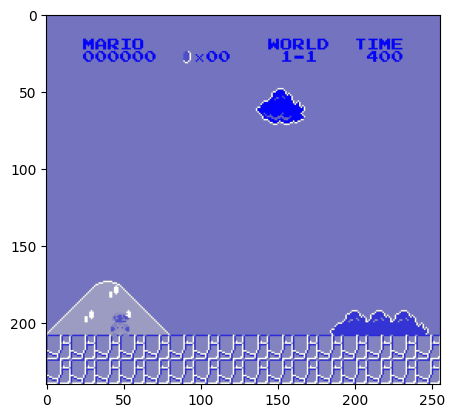

In [25]:
#show the state
# Check the shape of the observation to ensure it's stacking frames
print(f"Observation after step - shape: {obs.shape}")
plt.imshow(obs[0])
print(len(obs))

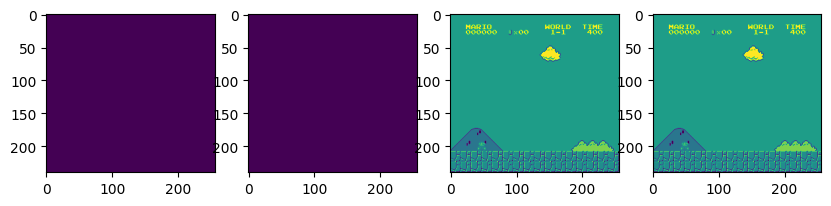

In [26]:
plt. figure(figsize=(10,8))
for idx in range(obs.shape[3]) :
    plt.subplot (1,4, idx+1)
    plt.imshow(obs[0][:, :,idx])
plt.show()

## Train RL Model

In [27]:
#import PPO for algorithms
from stable_baselines3 import PPO
#import base callback for saving models
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.callbacks import CheckpointCallback


In [28]:
#From Tutorial video
#will take a lot of space, so make it save every 50k steps
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [29]:
#CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
CHECKPOINT_DIR = "./checkpoints/"
callback = CheckpointCallback(save_freq=10000, save_path=CHECKPOINT_DIR, name_prefix="ppo_model")

In [30]:
#callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR) #save model every 50k steps

In [31]:
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate = 0.000001, n_steps=512)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [32]:
checkpoint_files = [f for f in os.listdir(CHECKPOINT_DIR) if f.endswith('.zip')]

if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda f: os.path.getctime(os.path.join(CHECKPOINT_DIR, f)))
    latest_checkpoint_path = os.path.join(CHECKPOINT_DIR, latest_checkpoint)

    # Load the model from the latest checkpoint
    model = PPO.load(latest_checkpoint_path)
    
    # Calculate remaining timesteps
    remaining_timesteps = 1000000 - model.num_timesteps
    model.set_env(env)
    #model.learn(total_timesteps=remaining_timesteps, callback=callback)
else:
    print("No checkpoints found. Ensure checkpoints are being saved correctly.")

No checkpoints found. Ensure checkpoints are being saved correctly.


In [33]:
#print(model.num_timesteps)

In [34]:
#model = PPO.load(latest_checkpoint_path)

In [35]:
#model.set_env(env)

In [36]:
model.learn(total_timesteps=1000000 - model.num_timesteps, callback=callback)

Logging to ./logs/PPO_6


----------------------------
| time/              |     |
|    fps             | 112 |
|    iterations      | 1   |
|    time_elapsed    | 4   |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 10            |
|    iterations           | 2             |
|    time_elapsed         | 102           |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 1.0193326e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | 0.0057        |
|    learning_rate        | 1e-06         |
|    loss                 | 234           |
|    n_updates            | 10            |
|    policy_gradient_loss | 2.86e-05      |
|    value_loss           | 738           |
-------------------------------------------
-----

In [37]:
model.save("mario_model")

## Test

In [38]:
#reload model from file
model = PPO.load("/train/best_model_10000")

FileNotFoundError: [Errno 2] No such file or directory: '/train/best_model_10000.zip'